In [1]:
from google.colab import drive
from os.path import join
import os

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Colab Notebooks/'       # path to your project on Drive



drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)


Mounted at /content/drive


In [ ]:
GIT_USERNAME = "ahhuang007" # replace with yours
GIT_TOKEN = os.environ['git_key_wsb']           # definitely replace with yours
GIT_REPOSITORY = "wallstreetbets"      # ...nah


In [ ]:
!mkdir "{PROJECT_PATH}"    # in case we haven't created it already   
%cd "{PROJECT_PATH}"

mkdir: cannot create directory ‘/content/drive/My Drive/Colab Notebooks/wallstreetbets’: File exists
/content/drive/My Drive/Colab Notebooks/wallstreetbets


In [ ]:
#GIT_PATH = "https://GIT_TOKEN@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git"
!git clone "https://$git_key_wsb@github.com/ahhuang007/wallstreetbets.git"
#!rsync -aP --exclude=data/ "{PROJECT_PATH}"/*  ./

Cloning into 'wallstreetbets'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (362/362), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 362 (delta 202), reused 293 (delta 133), pack-reused 0
Receiving objects: 100% (362/362), 3.16 MiB | 10.17 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [ ]:
%cd wallstreetbets

[Errno 2] No such file or directory: 'wallstreetbets'
/content


In [ ]:
!mv ./wallstreetbets/* "{PROJECT_PATH}"

In [ ]:
!rm -rf ./wallstreetbets

Pulling data from Github

In [ ]:
%cd drive/My Drive/Colab Notebooks/wallstreetbets

/content/drive/My Drive/Colab Notebooks/wallstreetbets


In [ ]:
!git pull origin

remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 47 (delta 31), reused 44 (delta 28), pack-reused 0
Unpacking objects: 100% (47/47), done.
From https://github.com/ahhuang007/wallstreetbets
   5db0c2d..0969224  main       -> origin/main
Updating 5db0c2d..0969224
Fast-forward
 .../gym_wsb/envs/__pycache__/val_env.cpython-37.pyc   | Bin 7979 -> 8420 bytes
 .../gym_wsb/envs/__pycache__/wsb_env.cpython-37.pyc   | Bin 8095 -> 8723 bytes
 gym-wsb/gym_wsb/envs/val_env.py                       |   3 +++
 gym-wsb/gym_wsb/envs/wsb_env.py                       |  17 ++++++++++++-----
 main.py                                               |   2 +-
 models/trained_models/trained_model_ppo_v43.zip       | Bin 0 -> 140328 bytes
 models/trained_models/trained_model_ppo_v44.zip       | Bin 0 -> 142516 bytes
 models/trained_models/trained_model_ppo_v45.zip       | Bin 0 -> 142544 bytes
 models/trained_model

Adding stuff to Github

In [ ]:
!git add .

In [ ]:
!git config --global user.email "ahhuang007@gmail.com"
!git config --global user.name "ahhuang007"

In [ ]:
!git commit -m "gotten most of the way to getting a forecasting network up and running"

[main 0d7c13d] gotten most of the way to getting a forecasting network up and running
 4 files changed, 602 insertions(+), 2 deletions(-)
 rewrite colab_ml_testing.ipynb (93%)
 rewrite colab_wsb.ipynb (97%)
 create mode 100644 lightning_logs/lightning_logs/version_0/events.out.tfevents.1651719883.4e271929e752.60.0
 create mode 100644 lightning_logs/lightning_logs/version_0/hparams.yaml


In [ ]:
!git remote set-url origin https://$git_key_wsb@github.com/ahhuang007/wallstreetbets.git

In [ ]:
!git push origin

Counting objects: 9, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (9/9), 83.06 KiB | 5.54 MiB/s, done.
Total 9 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/ahhuang007/wallstreetbets.git
   0969224..0d7c13d  main -> main


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   colab_wsb.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


Actual Code Below

The reason for this Colab file is to explore the viability of using a NN instead of an RL policy - in theory, we already know a basic optimal policy (buy before it increases, sell before it decreases), we just need to figure out if it will increase/decrease beforehand, which a NN can maybe do.

In [ ]:
import pandas as pd

In [ ]:
%cd drive/MyDrive/Colab Notebooks/wallstreetbets

/content/drive/MyDrive/Colab Notebooks/wallstreetbets


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

class wsb_dataset(Dataset):
  """class for formatting training data"""

  def __init__(self, df, labels):
    self.df = df
    self.labels = labels
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    sample = self.df.iloc[idx, :]
    sample = np.array([sample])
    sample = sample.astype('float')#.reshape(-1, 2)
    label = self.labels[idx]
    return sample, label

In [ ]:
#Gathering data, formatting it for NN
from sklearn.preprocessing import MinMaxScaler

dfs = []
training_datas = []
cryptos = ['AAVE', 'ADA', 'ALGO', 'ATOM', 
           'AVAX', 'BCH', 'BTC', 'DOT', 
           'ETH', 'LINK', 'LRC', 'LTC', 
           'MANA', 'MATIC', 'SOL', 'UNI']
cryptos = ['BTC']
for c in cryptos:
    df = pd.read_csv('./data/' + c + '_data.csv')
    '''I think we'll do a similar plan to my source idea.
    5 months for training, 2 months for validation/tuning, 5 months for testing
    '''
    #dfs.append(df[38:175200].reset_index(drop = True))
    #Splitting data into training/validation/test
    
    df = df.drop(['timestamp', 'Unnamed: 0'], axis = 1)
    df = df[38:]

    #Normalizing data
    scaler = MinMaxScaler()
    df = pd.DataFrame(data = scaler.fit_transform(df))
    labels = df[3][1:].reset_index(drop = True)
    training = wsb_dataset(df[:175200].reset_index(drop = True), labels[:175200].reset_index(drop = True))
    validation = wsb_dataset(df[175200:282600].reset_index(drop = True), labels[175200:282600].reset_index(drop = True))
    testing = wsb_dataset(df[262800:-1].reset_index(drop = True), labels[262800:].reset_index(drop = True))
    training_datas.append([training, validation, testing])

In [ ]:
train_dataloader = DataLoader(training_datas[0][0], batch_size = 64)
valid_dataloader = DataLoader(training_datas[0][1], batch_size = 64)

In [ ]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 8])
Shape of y: torch.Size([64]) torch.float64


In [ ]:
##Create NN
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        #print(x)
        logits = self.linear_relu_stack(x)
        return logits


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = NeuralNetwork().to(device)
print(model)

In [ ]:
def weighted_mse_loss(input, target, weight):
    return torch.sum(weight * (input - target) ** 2)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
##Train NN
import time
def train(dataloader, model, loss_fn, optimizer, accs):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred.squeeze(), y.float())
        #print(pred)
        #print(loss)
        #time.sleep(10)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            #print(loss)
            loss, current = loss.item(), batch * len(X)
            
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            accs.append(loss)
    return accs

In [ ]:
for X, y in train_dataloader:
  print(X[0])
  preds = model(X.float())
  print(preds)
  print(loss_fn(preds.squeeze(), y.float()))
  break

In [ ]:
def test(dataloader, model, loss_fn, accs):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred.squeeze(), y.float()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accs.append(test_loss)
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return accs

In [ ]:
train_accs = []
test_accs = []

In [ ]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    if t < 2:
        train_accs = train(train_dataloader, model, loss_fn, optimizer, train_accs)
        test_accs = test(valid_dataloader, model, loss_fn, test_accs)
    elif t >= 2 and test_accs[-1] < test_accs[-2]:
        train_accs = train(train_dataloader, model, loss_fn, optimizer, train_accs)
        test_accs = test(valid_dataloader, model, loss_fn, test_accs)
    else:
        pass
print("Done!")

In [ ]:
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir('./nn_stuff/models') 
             if isfile(join('./nn_stuff/models', f))]
version = str(len(onlyfiles))

torch.save(model.state_dict(), "nn_stuff/models/model_" + version + ".pth")

Plotting data (pretty much just losses)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_accs)
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(test_accs)
plt.show()

In [ ]:
##Test model in testing data

#basic framework - for each timestep, we feed data into network to get prediction.
#If price will increase by enough, we buy/hold. If it will decrease, we sell/don't buy.

#Code for loading saved model
model = NeuralNetwork()
model.load_state_dict(torch.load("nn_stuff/models/model_4.pth"))

<All keys matched successfully>

In [ ]:
testing_loader = DataLoader(training_datas[0][2], batch_size = 1)

In [ ]:
for X, y in testing_loader:
  print(X)
  print(X[0])
  preds = model(X.float())
  print(preds)
  print(loss_fn(preds.squeeze(), y.float()))
  break

In [ ]:
#DCA approach - use max(10% of balance, $10) to buy, 10% of shares to sell
def sell_low(balance, shares, close):
    if shares > 0:
        #update balance
        amount = 
        balance += amount * close
        shares -= amount
    else:
        pass #No shares to sell!
    return balance, shares

def buy_high(balance, shares, close):
    if balance > 0:
        #update balance
        amount = max(0.1 * balance, 10)
        amount = min(balance, amount)
        shares += (amount / close)
        balance -= amount
        
    else:
        pass #No money to buy!
    return balance, shares

In [ ]:
#naive approach - all-in trades with no fees
def sell_low(balance, shares, close):
    if shares > 0:
        #update balance
        balance += shares * close
        shares = 0
    else:
        pass #No shares to sell!
    return balance, shares

def buy_high(balance, shares, close):
    if balance > 0:
        #update balance
        shares += (balance / close)
        balance = 0
        
    else:
        pass
    return balance, shares

In [ ]:
balance = 100
shares = 0
counter = 262800
orig_df = pd.read_csv('./data/BTC_data.csv')[262799:]
total = []
cur = orig_df.loc[262799, "close"]
for X, y in testing_loader:
    if counter % 10000 == 0:
        print("Timestep {}: Balance is {}, shares is {}, total is {}".format(counter, balance, shares, total[-1]))
    pred = model(X.float()).item()
    cur_norm = X[0][0][3].item()
    #Figuring out which action to take
    if pred > cur_norm:
        balance, shares = buy_high(balance, shares, cur)
        #print("buying")
    elif pred < cur_norm:
        balance, shares = sell_low(balance, shares, cur)
        #print("selling")
    #time.sleep(3)
    total.append(balance + shares * cur)
    #Updating for next step
    counter += 1
    cur = orig_df.loc[counter, "close"]

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(total)
plt.show()

In [ ]:
#Downloading file
from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('example.txt')

So the traditional NN didn't pan out - will try using time series forecasting instead to see results

In [ ]:
!pip install pytorch_lightning

In [ ]:
!pip install pytorch_forecasting

In [ ]:
import os

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
#Various imports

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('./data/BTC_data.csv')
'''I think we'll do a similar plan to my source idea.
5 months for training, 2 months for validation/tuning, 5 months for testing
'''
#dfs.append(df[38:175200].reset_index(drop = True))
#Splitting data into training/validation/test

df = df.drop(['Unnamed: 0'], axis = 1)
df["time_idx"] = [int(x/60) for x in df["timestamp"]] 
df["crypto"] = "BTC"

#Apparently I have some missing timestamps, which is super weird

In [ ]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="close",
    group_ids=["crypto"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["crypto"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "open",
        "high",
        "low",
        "close",
        "volume",
        "MACD",
        "CCI",
        "ADX",
        "RSI"
    ],
    target_normalizer=GroupNormalizer(
        groups=["crypto"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps = True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


27.580078125

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
#This broke pytorch_lightning before, beware!

In [ ]:
# configure network and trainer
pl.seed_everything(4)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    log_every_n_steps = 25
)

Global seed set to 4
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 24.8k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/wallstreetbets/.lr_find_e10efe23-11ed-4e82-af6a-886814ee9311.ckpt
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1719: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None, 'save_on_train_epoch_end': None}"].
  "Be aware that when using `ckpt_path`,"


suggested learning rate: 0.15135612484362077


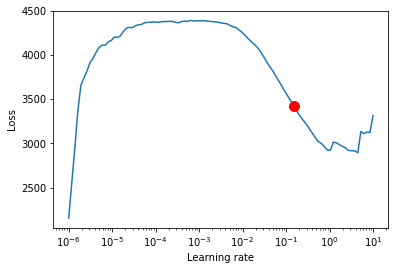

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 24.8k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: lightning_logs/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 224   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

RuntimeError: ignored